## Deep Learning Approaches for RF-based detection & classification
Transfer learning with a fully connected layer

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models
import torchvision.transforms as transforms

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from file_paths import *

from nn_functions import runkfoldcv
import cv2

from models import *
# from torchsummary import summary

In [46]:
import importlib
import loading_functions
importlib.reload(loading_functions)
from loading_functions import *

### Load Features

In [47]:
feat_name = 'SPEC' # 'RAW' or 'PSD' or 'SPEC'
t_seg = 20
n_per_seg = 1024

output_name = 'drones'
feat_format = 'IMG'# ARR, IMG
which_dataset = 'dronedetect'
output_tensor = True

# dataset specific parameters
drrf_highlow = 'H'
drde_ints = ['WIFI','CLEAN','BLUE','BOTH']

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, output_tensor, drrf_highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, output_tensor, drde_ints)

Loading DroneDetect Dataset
Directory Name:  /home/kzhou/main/Features/IMG_SPEC_1024_20/
dataset size 36778
shape of each item torch.Size([224, 224, 3])


In [48]:
print(dataset.__getitem__(100)[0].shape)
dataset.__getitem__(100)[0].dtype

torch.Size([224, 224, 3])


torch.float32

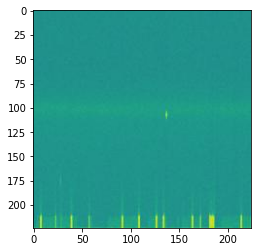

In [49]:
if feat_format =='IMG':
#      cv2.imshow()
    plt.imshow(dataset.__getitem__(90)[0])

In [50]:
dataset.__getitem__(100)[0][0].min()

tensor(0.1059)

## Run Model

In [51]:
num_classes = len(dataset.unique_labels)
which_model = 'vgg' # or 'resnet'
if which_model == 'vgg':
    Model = VGGFC(num_classes, isarray=(feat_format=='ARR'))
elif which_model == 'resnet':
    Model = ResNetFC(num_classes)
elif which_model == '1dconv':
    Model = RFUAVNet(num_classes)

In [52]:
# test_samp = dataset.__getitem__(40)[0]
# test_samp = torch.unsqueeze(test_samp, 1)
# test_samp.shape

In [54]:
Model.isarray = False

In [55]:
test_samp = dataset.__getitem__(90)[0]
test_samp = torch.unsqueeze(test_samp, 0)
# test_samp = test_samp.repeat(1,3,1,1) 

Model(test_samp)

tensor([[-0.1161, -0.0523, -0.2829, -0.3557,  0.3100,  0.0408,  0.0182]],
       grad_fn=<AddmmBackward0>)

In [56]:
# num_workers = 19
# train_val_test_split = [0.75, 0.05, 0.2]
# train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, (int(np.ceil(train_val_test_split[0]*len(dataset))), int(np.ceil(train_val_test_split[1]*len(dataset))), int(train_val_test_split[2]*len(dataset))))

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, num_workers=num_workers)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


In [57]:
# Configuration options
k_folds = 5

batch_size = 64 # 128
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=7, bias=True)
Starting epoch 1
    Loss after mini-batch    50: 2.54696
    Loss after mini-batch   100: 1.46939
    Loss after mini-batch   150: 1.36597
    Loss after mini-batch   200: 1.45641
    Loss after mini-batch   250: 1.36276
    Loss after mini-batch   300: 1.40600
    Loss after mini-batch   350: 1.66215
    Loss after mini-batch   400: 1.52499
    Loss after mini-batch   450: 1.54254
Epoch [1/10], Loss: 1.2062
Starting epoch 2
    Loss after mini-batch    50: 0.97735
    Loss after mini-batch   100: 0.98177
    Loss after mini-batch   150: 1.04197
    Loss after mini-batch   200: 0.88023
    Loss after mini-batch   250: 0.89569
    Loss after mini-batch   300: 1.17004
    Loss after mini-batch   350: 1.40436
    Loss after mini-batch   400: 1.32955
    Loss after mini-batch   450: 1.17138
Epoch [2/10], Loss: 0.6343
Starting e

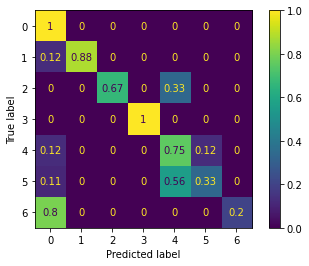

FOLD 1
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=7, bias=True)
Starting epoch 1
    Loss after mini-batch    50: 2.23148
    Loss after mini-batch   100: 1.51450
    Loss after mini-batch   150: 1.54175
    Loss after mini-batch   200: 1.71562
    Loss after mini-batch   250: 1.79522
    Loss after mini-batch   300: 1.42212
    Loss after mini-batch   350: 1.32017
    Loss after mini-batch   400: 1.54908
    Loss after mini-batch   450: 1.51461
Epoch [1/10], Loss: 0.6857
Starting epoch 2
    Loss after mini-batch    50: 0.87720
    Loss after mini-batch   100: 0.92597
    Loss after mini-batch   150: 1.09517
    Loss after mini-batch   200: 1.07397
    Loss after mini-batch   250: 1.09537
    Loss after mini-batch   300: 1.15567
    Loss after mini-batch   350: 1.20941
    Loss after mini-batch   400: 1.13898
    Loss after mini-batch   450: 1.07822
Epoch [2/10], Loss: 0.4862
Starting epoch 3
    Loss after mini-batch 

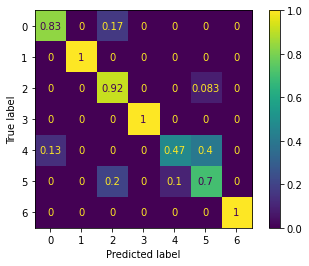

FOLD 2
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=7, bias=True)
Starting epoch 1
    Loss after mini-batch    50: 2.72564
    Loss after mini-batch   100: 1.71279
    Loss after mini-batch   150: 1.23924
    Loss after mini-batch   200: 1.26499
    Loss after mini-batch   250: 1.39574
    Loss after mini-batch   300: 1.42434
    Loss after mini-batch   350: 1.34376
    Loss after mini-batch   400: 1.31527
    Loss after mini-batch   450: 1.49157
Epoch [1/10], Loss: 3.5321
Starting epoch 2
    Loss after mini-batch    50: 1.05479
    Loss after mini-batch   100: 0.97877
    Loss after mini-batch   150: 0.87605
    Loss after mini-batch   200: 1.39400
    Loss after mini-batch   250: 1.33601
    Loss after mini-batch   300: 1.19282
    Loss after mini-batch   350: 0.96030
    Loss after mini-batch   400: 1.05254
    Loss after mini-batch   450: 1.58377
Epoch [2/10], Loss: 1.0177
Starting epoch 3
    Loss after mini-batch 

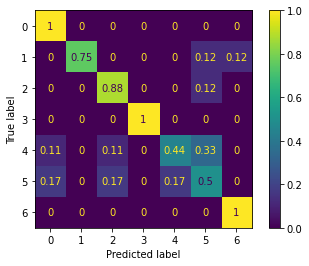

FOLD 3
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=7, bias=True)
Starting epoch 1
    Loss after mini-batch    50: 3.22239
    Loss after mini-batch   100: 1.40306
    Loss after mini-batch   150: 1.43364
    Loss after mini-batch   200: 1.62458
    Loss after mini-batch   250: 1.33161
    Loss after mini-batch   300: 1.38535
    Loss after mini-batch   350: 1.42851
    Loss after mini-batch   400: 1.47481
    Loss after mini-batch   450: 1.44724
Epoch [1/10], Loss: 0.9243
Starting epoch 2
    Loss after mini-batch    50: 0.99735
    Loss after mini-batch   100: 1.04954
    Loss after mini-batch   150: 1.05063
    Loss after mini-batch   200: 1.21576
    Loss after mini-batch   250: 0.94415
    Loss after mini-batch   300: 1.01625
    Loss after mini-batch   350: 1.00815
    Loss after mini-batch   400: 1.09514
    Loss after mini-batch   450: 1.24016
Epoch [2/10], Loss: 1.6543
Starting epoch 3
    Loss after mini-batch 

In [ ]:

trainedModel, res_acc, res_f1, res_runtime = runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------------------------------------------------------------------------------------